# CS 677 Deep Learning - Project #1 CVPR 2020 CLVision Challenge

## By Andres Castellano, Benedict Waiharo, Alan Yeung

A description of the challenge taken verbatim from https://sites.google.com/view/clvision2020/challenge is shown here for easy reference.

"During the past few years we have witnessed a renewed and growing attention to Continuous Learning (CL) [Parisi, 2019]. The interest in CL is essentially two folds. From the artificial intelligence perspective, CL can be seen as another important step towards the grand goal of creating autonomous agents which can learn continuously and acquire new complex skills and knowledge. From a more practical perspective, CL looks particularly appealing because it enables two important properties: adaptability and scalability. One of the key hallmarks of CL techniques is the ability to update the models by using only recent data (i.e., without accessing old data). This is often the only practical solution when learning on the edge from high-dimensional streaming or ephemeral data, which would be impossible to keep in memory and process from scratch every time a new piece of information becomes available. Unfortunately, when (deep or shallow) neural networks are trained only on newdata, they experience a rapid overriding of their weights with a phenomenon known in literature catastrophic forgetting.

The challenge will be based on the CORe50 dataset and composed of three tracks:

1. New Instances (NI): In this setting 8 training batches of the same 50 classes are encountered over time. Each training batch is composed of different images collected in different environmental conditions.
2. Multi-Task New Classes (Multi-Task-NC)*: In this setting the 50 different classes are split into 9 different tasks: 10 classes in the first batch and 5 classes in the other 8. In this case the task label will be provided during training and test.
3. New Instances and Classes (NIC): this protocol is composed of 391 training batches containing 300 images of a single class. No task label will be provided and each batch may contain images of a class seen before as well as a completely new class."



# Introduction

With the above challenge understanding and scope. Our first task is to read over all top ten challenger papers. This will provide some hindsights to what others have achieved to serve as a base for our solution. In addition from researches, We came across a Tensorflow tutorial and were inspired to enhance the transfer learning and fine-tuning (TLFT) as a solution towards achieving the goals in this challenge. The base solution code of this TLFT is part of the Tensorflow tutorial (https://www.tensorflow.org/tutorials/images/transfer_learning#create_the_base_model_from_the_pre-trained_convnets) and the credits goes to The Tensorflow authors.

Our contributions to the code in this jupyter notebook is the application of using TLFT to potentially overcome catastrophic forgetting and applying my class learning to practical experimentation of Deep Learning algorithms/techniques. The comments will highlight where contributions and enhancements were made to differentiate from original materials. 


# Backgrounds on Imagenet, Transfer learning and Fine-tuning


Deep learning have made much advancement in the past decade. Thanks to collaboration from the educational communities and formalizing standard set of images called the Imagenet. Data scientists, engineers and students are able to take advantages of it and to test and validate their deep learning algorithms with others. 

In addition to use those image repositories for classification tasks. Models trained on those images are made available on the public domain. These models are the results of extensive image training that others can use as a base model to build upon. For this reason that we chose the TLFT method using one of these models.

"Resnet50 V2" is one of those models and the one we will use over the original model "MobileNet V2" in the tutorial. "Resnet50 V2" was trained with 1000 classes. Using such a pre-trained model saves time as others have spent time and compute resources into it. What were learnt are the features of images like the weights and biases and these values can be transferred to build upon and fine-tuned.



1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

 You do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

1. Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.



# Summary of Top Ten Winners of CVPR Challenge Methodologies

* The winner of this challenge used Experienced Replay implementation with DenseNet-161 base model and leverage data augmentation for better generalization to take the gold metal.
* The silver medalist adopted the WideResNet-50 base model with feature extraction and also leveraged data augmentation. They observed that CORE50 images were only 128x128 and to achieve better integration with the WideResNet-50 model that was trained with 224x224 images. They ensure that CORE50 images were resized to 224x224 in this competition.
* The bronze medalist applied Experienced Replay with episodic memory and used Resnet-50 base model.

The other implementations appear in the ten top are Learning without Forgetting (LwF), Rehearal, Elastic Weight Consolidation (EWC) with various memory techniques. The ResNet base models are popular among these contenders.

# Project Work

We will comment on the following code section with our contributions and enhancements from the base tutorial.

## Importing python modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

## Preparing local setup to conduct Core50 with two classes

Preparing local copy of "partial" core50 data for two classes only (to be explained in the summary section)
* NOTE for colab usage: individual needs to upload from the following github repo projectdata.zip to continue with colab.
https://github.com/ayhkusa/cvpr_clvision_challenge/blob/feature/alan/partial/projectdata.zip
* github - https://github.com/ayhkusa/cvpr_clvision_challenge/tree/master


In [2]:

if os.name == 'posix':
    print('Prep linux') #
    current_cwd = os.getcwd()
    print(current_cwd)
    !unzip -n ./partial/projectdata.zip -d ./partial
else:
    print('please unzip the dataset per your platform')
    print('unzip the projectdata.zip in the partial directory')
    print('projectdata.zip is to be unzipped into this directory structure')
    print('/partial/core50/data/core50_128x128/[s2 s3]')

    

Prep linux
/home/ubuntu/cvpr_clvision_challenge
Archive:  ./partial/projectdata.zip



## Data preprocessing

### Preparing data sources

Due to the frequenct switching between different platforms, a function was created to facilitate easy switching. Colab users should use source_data(2).

In [3]:

# -------------------
def source_data(source):
    current_cwd = os.getcwd()
    #path_to_zip = 'C:\\homestuff12\\Alan\\NJIT\\CS677 - Deep Learning\\cvpr_clvision_challenge\\partial\\core50\\data\\'
    #path_to_zip = '/home/ubuntu/cvpr_clvision_challenge/core50/data/'    #All

    if source == 1:
        print("data source 0 is s1 for all classes")
        path_to_zip = current_cwd+'/core50/data/'
        PATH2 = path_to_zip+'core50_128x128'
        train_dir0 = os.path.join(PATH2, 's1')
        validation_dir0 = os.path.join(PATH2, 's2')        
        train_dir1 = os.path.join(PATH2, 's2')
        validation_dir1 = os.path.join(PATH2, 's1')
    elif source == 2:
        # For use with colab
        print("Select for two classes from core50")
        path_to_zip = current_cwd+'/partial/core50/data/'    
        PATH2 = path_to_zip+'core50_128x128'
        print("data source 0 is s2")
        train_dir0 = os.path.join(PATH2, 's1')
        validation_dir0 = os.path.join(PATH2, 's2')        
        train_dir1 = os.path.join(PATH2, 's2')
        validation_dir1 = os.path.join(PATH2, 's1')        
    else:
        print("no input")
    
    print(PATH2)
    return (train_dir0,validation_dir0,train_dir1,validation_dir1)

>We ensure that the input images are resized from 128x128 to 224x224 to prevent image detail lost in the convolution and pooling layers and also to enhance performance.

In [4]:
def trainset(train_dir,BATCH_SIZE = 64,IMG_SIZE = (224, 224)):
    #BATCH_SIZE = 32
    #IMG_SIZE = (160, 160) original
    train_dataset = image_dataset_from_directory(train_dir,
                                                 shuffle=True,
                                                 batch_size=BATCH_SIZE,
                                                 image_size=IMG_SIZE)
    print(train_dataset.class_names)
    return train_dataset



In [5]:
def val_dataset(validation_dir,BATCH_SIZE = 64,IMG_SIZE = (224, 224)):
    validation_dataset = image_dataset_from_directory(validation_dir,
                                                      shuffle=True,
                                                      batch_size=BATCH_SIZE,
                                                      image_size=IMG_SIZE)
    print(validation_dataset.class_names)
    return validation_dataset



As the original dataset doesn't contains a test set, you will create one. To do so, determine how many batches of data are available in the validation set using ```tf.data.experimental.cardinality```, then move 20% of them to a test set.
(part of original tutorial content)

In [6]:
def test_dataset(validation_dataset):
    val_batches = tf.data.experimental.cardinality(validation_dataset) #number of sets = BATCH_SIZE
    test_dataset = validation_dataset.take(val_batches // 5) # test = 32 // 5 = 6 taken from validation
    validation_dataset = validation_dataset.skip(val_batches // 5) # so validation to skip(6) = 32-6=26
    print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
    print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))
    print(test_dataset)
    print(validation_dataset)
    
    return (val_batches,test_dataset,validation_dataset)



### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. (part of original tutorial content)

In [7]:
def prefetch(train,validation,test):
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    train_dataset = train.prefetch(buffer_size=AUTOTUNE)
    validation_dataset = validation.prefetch(buffer_size=AUTOTUNE)
    test_dataset = test.prefetch(buffer_size=AUTOTUNE)
    
    return (train_dataset,validation_dataset,test_dataset)

### Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce [overfitting](part of original tutorial content)

In [8]:
def data_aug():
    data_augmentation = tf.keras.Sequential([
      tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
      tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    ])
    return data_augmentation

### Rescale pixel values

In a moment, you will download `tf.keras.applications.MobileNetV2` for use as your base model. This model expects pixel vaues in `[-1,1]`, but at this point, the pixel values in your images are in `[0-255]`. To rescale them, use the preprocessing method included with the model.
(part of original tutorial content)

In [9]:
def prepro_rescale():
    preprocess_input = tf.keras.applications.resnet_v2.preprocess_input
    rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)
    
    return (preprocess_input, rescale)

## Create the base model from the pre-trained convnets

We have converted the original tutorial using MobileNet to ResNet50 here.

The ResNet50 model is pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [10]:
def create_base():
    # Create the base model from the pre-trained model MobileNet V2
    IMG_SIZE=(224,224)
    IMG_SHAPE = IMG_SIZE + (3,)
    print("image size ", IMG_SIZE)
    print("image shape ", IMG_SHAPE)
    # base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
    base_model = tf.keras.applications.ResNet50V2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
    #print(base_model.summary())
    return base_model

## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier. (original content)

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. S
o setting the entire model's `trainable` flag to False will freeze all of them. (original content)

In [11]:
def feature_extractor(base_model,train_dataset):
    print("Freezing the convolutional base")
    base_model.trainable = False
    image_batch, label_batch = next(iter(train_dataset))
    feature_batch = base_model(image_batch)
    print(image_batch.shape) #image_batch)
    print(label_batch.shape) #label_batch)
    print(feature_batch.shape)
    
    return (base_model,image_batch,label_batch,feature_batch)

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial. 

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics. 

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.
(original content)

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image. (original content)

In [12]:
def add_classify_head_layer(feature_batch):
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    feature_batch_average = global_average_layer(feature_batch)
    print(global_average_layer)
    print(feature_batch_average.shape)
    
    return feature_batch_average

Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value.  Positive numbers predict class 1, negative numbers predict class 0. (original content)

In [13]:
def add_predict_layer(feature_batch_average):
    #prediction_layer = tf.keras.layers.Dense(1, activation = 'sigmoid') #unable to prediction's single class
    prediction_layer = tf.keras.layers.Dense(1) # doesn't do well on 2+ classes 
    prediction_batch = prediction_layer(feature_batch_average)
    print(prediction_batch.shape)
    
    return prediction_batch

## With Augmentation

### Compile the model

Compile the model before training it. Since there are two classes, use a binary cross-entropy loss with `from_logits=True` since the model provides a linear output. (original content)

In [14]:
def train_model(base_model,base_learning_rate = 0.0001):
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    #prediction_layer = tf.keras.layers.Dense(1, activation = 'sigmoid') #unable to prediction's single class
    prediction_layer = tf.keras.layers.Dense(1) # doesn't do well on 2+ classes 
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = global_average_layer(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)
    
    # base_learning_rate = 0.0001
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print("trainable variables ", len(model.trainable_variables))
    
    return model

The 2.5M parameters in MobileNet are frozen, but there are 1.2K _trainable_ parameters in the Dense layer.  These are divided between two `tf.Variable` objects, the weights and biases.

## Training the model

In [15]:
def evaluate_dataset(model,dataset,msg):
    print("Evaluating model - ", msg)
    loss, accuracy = model.evaluate(dataset)
    print("initial loss: {:.2f}".format(loss))
    print("initial accuracy: {:.2f}".format(accuracy))

In [16]:
def fit_train(train_model,train_dataset,validation_dataset,initial_epochs):
    print("fit train")
    history = train_model.fit(train_dataset,
                        epochs=initial_epochs,
                        validation_data=validation_dataset)
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy - fit train')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss - fit train')
    plt.xlabel('epoch')
    plt.show()
    
    return (history,acc,val_acc,loss,val_loss)


### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the ResNet50 V2 base model as a fixed feature extractor.

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer. (original content)

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an ResNet50 V2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole ResNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

(original content)

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training. (original content)

### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly. (original content)

In [17]:
def tune_base_model(base_model,train_model,base_learning_rate = 0.0001):
    print("Unfreeze top layers")
    base_model.trainable = True
    # Let's take a look to see how many layers are in the base model
    print("Number of layers in the base model: ", len(base_model.layers))
    # Fine-tune from this layer onwards
    fine_tune_at = 100
    
    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable =  False
    #print(base_model.summary())    
    train_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                       optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
                       metrics=['accuracy'])
    #print(train_model.summary())
    print("Number of trainable variables ", len(train_model.trainable_variables))
    
    return train_model


### Continue training the model

In [18]:
def model_fit2(model,train_dataset,validation_dataset,history,initial_epochs,fine_tune_epochs,acc,val_acc,loss,val_loss):
    print("model fit 2")
    # initial_epochs = 10
    # fine_tune_epochs = 10
    total_epochs =  initial_epochs + fine_tune_epochs

    history_fine = model.fit(train_dataset,
                             epochs=total_epochs,
                             initial_epoch=history.epoch[-1],
                             validation_data=validation_dataset)
    
    acc += history_fine.history['accuracy']
    val_acc += history_fine.history['val_accuracy']

    loss += history_fine.history['loss']
    val_loss += history_fine.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.ylim([0.8, 1])
    plt.plot([initial_epochs-1,initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy - fit2')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.ylim([0, 1.0])
    plt.plot([initial_epochs-1,initial_epochs-1],
             plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss - fit2')
    plt.xlabel('epoch')
    plt.show()
    
    return (history_fine,acc,val_acc,loss,val_loss)

### Evaluation and prediction

Finaly you can verify the performance of the model on new data using test set.

In [19]:
def evaluate_model(tune_model, test_dataset):
    loss, accuracy = tune_model.evaluate(test_dataset)
    print('Test loss :', loss)
    print('Test accuracy :', accuracy)
    
    return (loss, accuracy)



In [20]:
def predict_image(tune_model,test_dataset):
    #Retrieve a batch of images from the test set
    image_batch, label_batch = test_dataset.as_numpy_iterator().next()
    predictions = tune_model.predict_on_batch(image_batch).flatten()

    # Apply a sigmoid since our model returns logits
    predictions = tf.nn.sigmoid(predictions)
    predictions = tf.where(predictions < 0.5, 0, 1)

    print('Predictions:\n', predictions.numpy())
    print('Labels:\n', label_batch)

    plt.figure(figsize=(10, 10))
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(image_batch[i].astype("uint8"))
      #plt.title(class_names[predictions[i]])
      plt.title(label_batch[i])  
      plt.axis("off")
        
   


# Start of first batch of data s1

> The validation of images on untrained model is less than 50% accuracy

In [21]:
print("# Start of 1st dataset using train_dir0 ...")

train_dir0,validation_dir0,train_dir1,validation_dir1 = source_data(2)

train_dataset0 = trainset(train_dir0,BATCH_SIZE=32)
validation_dataset0 = val_dataset(validation_dir0,BATCH_SIZE=32)
val_batches0,test_dataset0,validation_dataset0 = test_dataset(validation_dataset0)
train_dataset0,validation_dataset0,test_dataset0 = prefetch(train_dataset0,validation_dataset0,test_dataset0)

data_augmentation = data_aug()
preprocess_input, rescale = prepro_rescale()
base_model0 = create_base()

base_model0,image_batch0,label_batch0,feature_batch0 = feature_extractor(base_model0,train_dataset0)
feature_batch_average0 = add_classify_head_layer(feature_batch0)
prediction_batch0 = add_predict_layer(feature_batch_average0)

train_model0 = train_model(base_model0,base_learning_rate = 0.001)

evaluate_dataset(train_model0, validation_dataset0, "validation data s2")
evaluate_dataset(train_model0, test_dataset0, " test data s2")


# Start of 1st dataset using train_dir0 ...
Select for two classes from core50
data source 0 is s2
/home/ubuntu/cvpr_clvision_challenge/partial/core50/data/core50_128x128
Found 596 files belonging to 2 classes.
['o1', 'o2']
Found 600 files belonging to 2 classes.
['o1', 'o2']
Number of validation batches: 16
Number of test batches: 3
<TakeDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>
<SkipDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>
image size  (224, 224)
image shape  (224, 224, 3)
Freezing the convolutional base
(32, 224, 224, 3)
(32,)
(32, 7, 7, 2048)
(32, 2048)
(32, 1)
trainable variables  2
Evaluating model -  validation data s2
16/16 [==============================] - 2s 99ms/step - loss: 0.9676 - accuracy: 0.3909
initial loss: 0.97
initial accuracy: 0.39
Evaluating model -   test data s2
3/3 [==============================] - 0s 54ms/step - loss: 0.8937 - accuracy: 0.4167
initial loss: 0.89
initial accuracy: 0.42


### Let's train the model

> Training the model with improved the accuracy to over 99%

fit train
Epoch 1/25
19/19 [==============================] - 4s 195ms/step - loss: 0.5540 - accuracy: 0.7164 - val_loss: 0.3139 - val_accuracy: 0.8849
Epoch 2/25
19/19 [==============================] - 3s 171ms/step - loss: 0.1386 - accuracy: 0.9530 - val_loss: 0.2673 - val_accuracy: 0.8849
Epoch 3/25
19/19 [==============================] - 3s 172ms/step - loss: 0.0704 - accuracy: 0.9899 - val_loss: 0.2599 - val_accuracy: 0.8591
Epoch 4/25
19/19 [==============================] - 3s 172ms/step - loss: 0.0684 - accuracy: 0.9765 - val_loss: 0.2318 - val_accuracy: 0.8948
Epoch 5/25
19/19 [==============================] - 3s 174ms/step - loss: 0.0457 - accuracy: 0.9883 - val_loss: 0.2597 - val_accuracy: 0.8730
Epoch 6/25
19/19 [==============================] - 3s 173ms/step - loss: 0.0365 - accuracy: 0.9950 - val_loss: 0.2370 - val_accuracy: 0.8889
Epoch 7/25
19/19 [==============================] - 3s 172ms/step - loss: 0.0364 - accuracy: 0.9933 - val_loss: 0.2247 - val_accuracy: 0.9

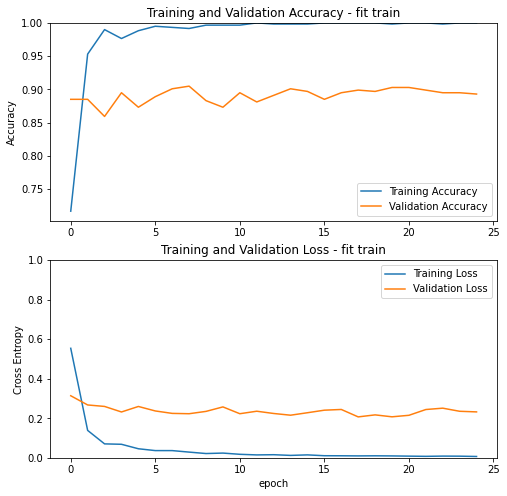

In [22]:

history0,acc,val_acc,loss,val_loss = fit_train(train_model0,train_dataset0,validation_dataset0,initial_epochs=25)


### Unfreezing top layers

> To enable the ability to update 84 variables

Unfreeze top layers
Number of layers in the base model:  190
Number of trainable variables  84
model fit 2
Epoch 25/30
19/19 [==============================] - 6s 318ms/step - loss: 1.0896 - accuracy: 0.9161 - val_loss: 0.2398 - val_accuracy: 0.8790
Epoch 26/30
19/19 [==============================] - 5s 269ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.2712 - val_accuracy: 0.8790
Epoch 27/30
19/19 [==============================] - 5s 271ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.2034 - val_accuracy: 0.8988
Epoch 28/30
19/19 [==============================] - 5s 272ms/step - loss: 0.1510 - accuracy: 0.9597 - val_loss: 0.5184 - val_accuracy: 0.8452
Epoch 29/30
19/19 [==============================] - 5s 275ms/step - loss: 9.9455e-04 - accuracy: 1.0000 - val_loss: 0.4329 - val_accuracy: 0.8571
Epoch 30/30
19/19 [==============================] - 5s 277ms/step - loss: 5.5283e-04 - accuracy: 1.0000 - val_loss: 0.8253 - val_accuracy: 0.8373


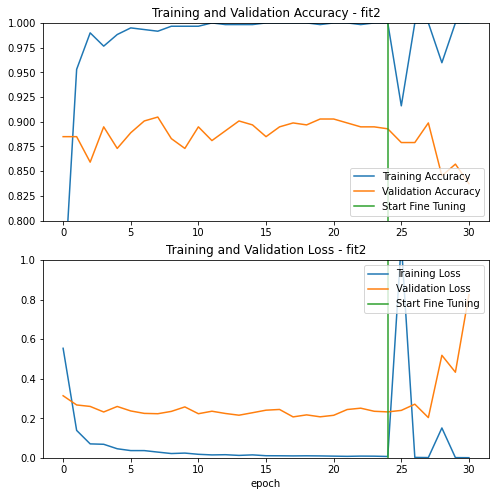

Evaluating model -  test with s2
3/3 [==============================] - 0s 61ms/step - loss: 0.7478 - accuracy: 0.8438
initial loss: 0.75
initial accuracy: 0.84
Predictions:
 [1 1 1 0 1 0 1 1 1 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 1 0 0 0 1 1]
Labels:
 [1 0 1 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1]


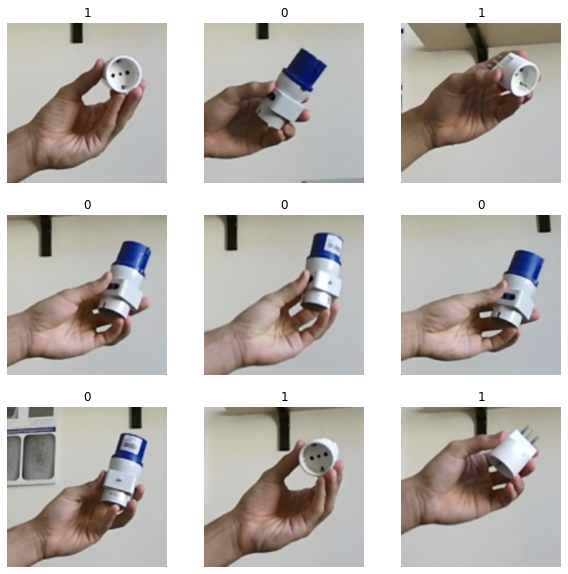

In [23]:
tune_model0 = tune_base_model(base_model0,train_model0,base_learning_rate = 0.001)
history1,acc,val_acc,loss,val_loss = model_fit2(tune_model0,train_dataset0,validation_dataset0,history0,
                                                initial_epochs=25,fine_tune_epochs=5,acc=acc,val_acc=val_acc,
                                                loss=loss,val_loss=val_loss)
evaluate_dataset(tune_model0, test_dataset0, "test with s2")
predict_image(tune_model0,test_dataset0)

>Checking the test data again before we switch to train on dataset #2

# Repeat of dataset #1 (train_dir0 ...) using same tuned model that have NOT been changed with dataset #2 yet
Evaluating model -  test with s2
3/3 [==============================] - 0s 61ms/step - loss: 0.6465 - accuracy: 0.8750
initial loss: 0.65
initial accuracy: 0.88
Predictions:
 [1 1 1 1 0 0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0]
Labels:
 [1 1 1 1 0 0 0 0 0 1 1 0 1 1 0 1 1 1 0 0 1 1 0 0 1 1 1 0 0 1 1 0]


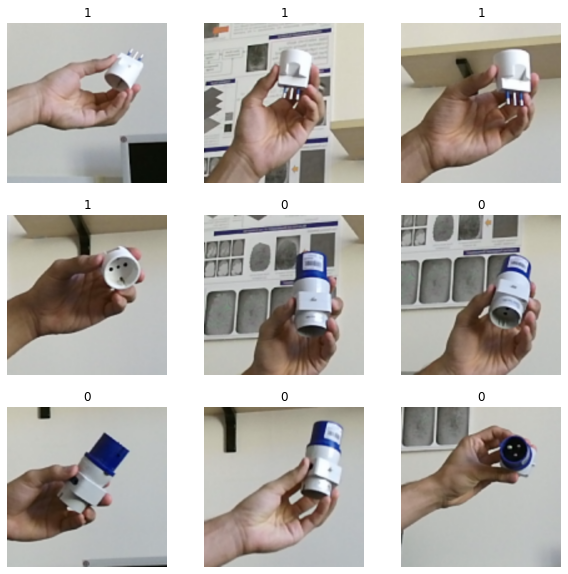

In [24]:
print("# Repeat of dataset #1 (train_dir0 ...) using same tuned model that have NOT been changed with dataset #2 yet")

evaluate_dataset(tune_model0, test_dataset0, "test with s2")
predict_image(tune_model0,test_dataset0)


## Start training on dataset s2

# Start of dataset #2 (train_dir1 ...) using same tuned model
Found 600 files belonging to 2 classes.
['o1', 'o2']
Found 596 files belonging to 2 classes.
['o1', 'o2']
Number of validation batches: 8
Number of test batches: 2
<TakeDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>
<SkipDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>
Freezing the convolutional base
(64, 224, 224, 3)
(64,)
(64, 7, 7, 2048)
(64, 2048)
(64, 1)
trainable variables  2
Evaluating model -  dataset s2
8/8 [==============================] - 1s 143ms/step - loss: 1.7127 - accuracy: 0.1026
initial loss: 1.71
initial accuracy: 0.10
fit train
Epoch 1/10
10/10 [==============================] - 4s 358ms/step - loss: 0.7327 - accuracy: 0.5317 - val_loss: 0.2269 - val_accuracy: 0.9594
Epoch 2/10
10/10 [==============================] - 4s 360ms/step - loss: 0.3262 - accuracy: 0.8733 - val_loss: 0.0477 - val_accuracy: 1.0000
Epoch 3/10
10/10 [===================

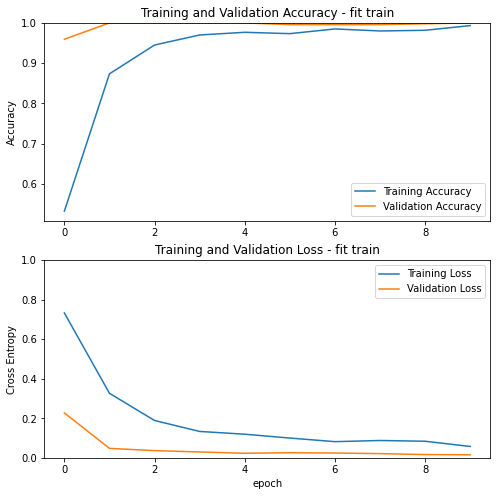

Unfreeze top layers
Number of layers in the base model:  190
Number of trainable variables  84
model fit 2
Epoch 10/30
10/10 [==============================] - 6s 605ms/step - loss: 2.0204 - accuracy: 0.8250 - val_loss: 0.0142 - val_accuracy: 1.0000
Epoch 11/30
10/10 [==============================] - 5s 521ms/step - loss: 0.0298 - accuracy: 0.9917 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 12/30
10/10 [==============================] - 5s 525ms/step - loss: 0.0043 - accuracy: 0.9983 - val_loss: 6.6500e-04 - val_accuracy: 1.0000
Epoch 13/30
10/10 [==============================] - 5s 528ms/step - loss: 0.0616 - accuracy: 0.9817 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 14/30
10/10 [==============================] - 5s 526ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 3.7950e-04 - val_accuracy: 1.0000
Epoch 15/30
10/10 [==============================] - 5s 527ms/step - loss: 4.8157e-04 - accuracy: 1.0000 - val_loss: 1.8420e-04 - val_accuracy: 1.0000
Epoch 16/30
10/10 [

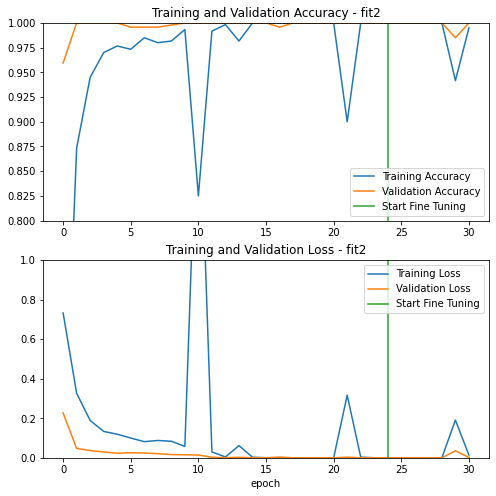

Evaluating model -  dataset s1
2/2 [==============================] - 0s 87ms/step - loss: 2.7948e-04 - accuracy: 1.0000
initial loss: 0.00
initial accuracy: 1.00
Predictions:
 [0 1 0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 1 0 1
 1 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 0 1 1 0 0]
Labels:
 [0 1 0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 1 0 1
 1 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 0 1 1 0 0]


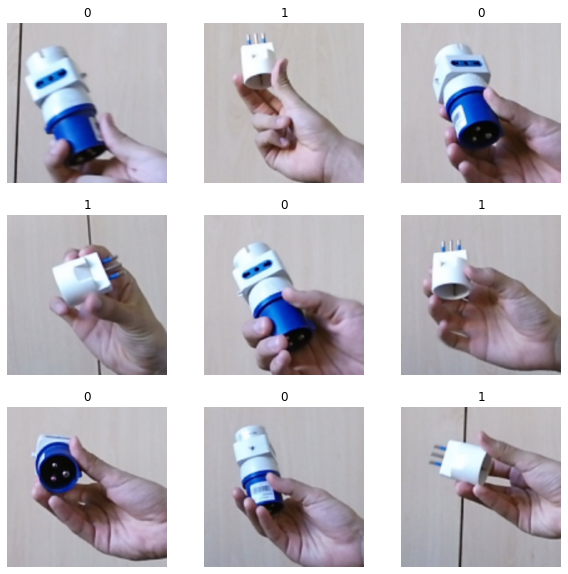

In [25]:
print("# Start of dataset #2 (train_dir1 ...) using same tuned model")

#train_dir0,validation_dir0,train_dir1,validation_dir1 = source_data(2)
train_dataset0 = trainset(train_dir1)
validation_dataset0 = val_dataset(validation_dir1)
val_batches0,test_dataset0,validation_dataset0 = test_dataset(validation_dataset0)
train_dataset0,validation_dataset0,test_dataset0 = prefetch(train_dataset0,validation_dataset0,test_dataset0)

#data_augmentation = data_aug()
#preprocess_input, rescale = prepro_rescale()
#base_model0 = create_base()

base_model0,image_batch0,label_batch0,feature_batch0 = feature_extractor(base_model0,train_dataset0)
feature_batch_average0 = add_classify_head_layer(feature_batch0)
prediction_batch0 = add_predict_layer(feature_batch_average0)

#enabled
train_model0 = train_model(base_model0,base_learning_rate = 0.001)

evaluate_dataset(train_model0, validation_dataset0,"dataset s2")
history0,acc,val_acc,loss,val_loss = fit_train(train_model0,train_dataset0,validation_dataset0,initial_epochs=10)
tune_model0 = tune_base_model(base_model0,train_model0,base_learning_rate = 0.001)
history1,acc,val_acc,loss,val_loss = model_fit2(tune_model0,train_dataset0,validation_dataset0,history0,
                                                initial_epochs=25,fine_tune_epochs=5,acc=acc,val_acc=val_acc,
                                                loss=loss,val_loss=val_loss)

evaluate_dataset(tune_model0, test_dataset0, "dataset s1")
predict_image(tune_model0,test_dataset0)


### Repeat of dataset #1 (s1) using same tuned model that have been changed with dataset s1 and s2

Found 600 files belonging to 2 classes.
['o1', 'o2']
Number of validation batches: 8
Number of test batches: 2
<TakeDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>
<SkipDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>
Evaluating model -  test with s2
2/2 [==============================] - 0s 121ms/step - loss: 1.3197e-04 - accuracy: 1.0000
initial loss: 0.00
initial accuracy: 1.00
Predictions:
 [1 1 1 1 0 0 0 1 1 1 1 1 1 0 0 1 0 1 1 1 0 1 0 1 1 1 0 1 1 0 1 1 0 0 0 1 0
 0 1 1 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1 1 0]
Labels:
 [1 1 1 1 0 0 0 1 1 1 1 1 1 0 0 1 0 1 1 1 0 1 0 1 1 1 0 1 1 0 1 1 0 0 0 1 0
 0 1 1 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1 1 0]


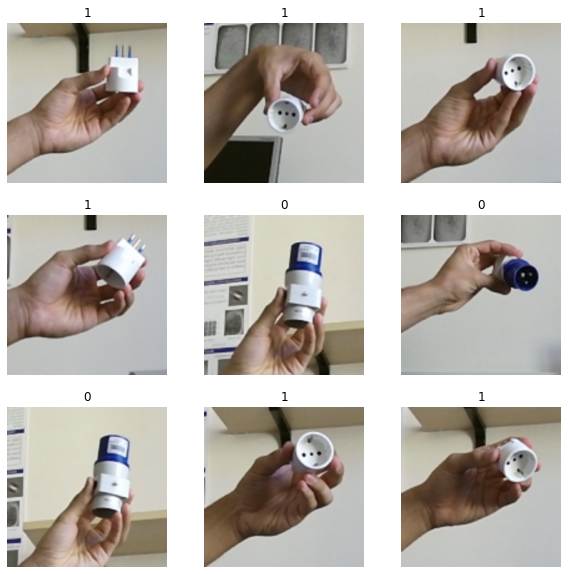

In [26]:

#train_dir0,validation_dir0,train_dir1,validation_dir1 = source_data(2)
#train_dataset0 = trainset(train_dir0)
validation_dataset0 = val_dataset(validation_dir0)

val_batches0,test_dataset0,validation_dataset0 = test_dataset(validation_dataset0)
#train_dataset0,validation_dataset0,test_dataset0 = prefetch(train_dataset0,validation_dataset0,test_dataset0)

evaluate_dataset(tune_model0, test_dataset0, "test with s2")
predict_image(tune_model0,test_dataset0)



### Repeat of dataset #2 (s2) using same tuned model that have been changed with s1 and s2


Found 596 files belonging to 2 classes.
['o1', 'o2']
Number of validation batches: 8
Number of test batches: 2
<TakeDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>
<SkipDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>
Evaluating model -  test with s1
2/2 [==============================] - 0s 106ms/step - loss: 0.0028 - accuracy: 1.0000
initial loss: 0.00
initial accuracy: 1.00
Predictions:
 [1 0 0 0 1 1 1 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 1 0 0 1 1 0 1 1 1 1 0 0 0 0
 1 0 0 0 1 0 1 0 1 0 0 0 0 0 1 1 1 1 0 0 1 1 0 0 1 1 1]
Labels:
 [1 0 0 0 1 1 1 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 1 0 0 1 1 0 1 1 1 1 0 0 0 0
 1 0 0 0 1 0 1 0 1 0 0 0 0 0 1 1 1 1 0 0 1 1 0 0 1 1 1]


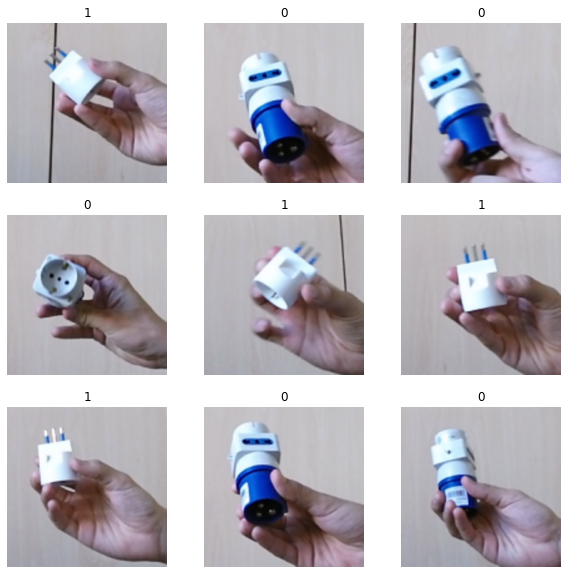

In [27]:
# cvpr_clvision_challenge/core50/data/core50_challenge_test
#train_dir0,validation_dir0,train_dir1,validation_dir1 = source_data(2)
#train_dataset0 = trainset(train_dir1)
validation_dataset0 = val_dataset(validation_dir1)

val_batches0,test_dataset0,validation_dataset0 = test_dataset(validation_dataset0)
#train_dataset0,validation_dataset0,test_dataset0 = prefetch(train_dataset0,validation_dataset0,test_dataset0)

evaluate_dataset(tune_model0, test_dataset0, "test with s1")
predict_image(tune_model0,test_dataset0)

# Summary

We have shown here that the transfer learning with fine-tunning is capable to retaining learning. This is a small experiment with two classes. We understand that to perform the same experiment with all the datasets with this model, we'll need to revise the model to compile with (loss=tf.keras.losses.CategoricalCrossentropy()) option instead of the loss=tf.keras.losses.BinaryCrossentropy(); unfortunately that we are unable to resolve a technical issue to present the full solution here. But we will keep trying and finalize this solution even if the project is over.

# More Observations and Investigations of Continual Learning


## Background
The basic premise of a machine learning, or deep learning algorithm, is to familiarize a computer with the numerical representation of processes or objects. For example: in a regression problem, a programmer will show a computer a set of target variables and a set of features that need to be used to predict that target variable. In addition, the programmer will give the computer a routine by which the computer needs to learn. The computer will perform the routine and update its assumptions itireatively until the computer and programmer are both satisfied with the accuracy of the model created to predict the target variable. A different and perhaps more concrete example is that of a classification algorithm. Imagine that a program needs to be created to classify images of cats versus dogs. In this case, the programmer feeds the computer a set of images where some images are cats and others are dogs, and each image is labeled accordingly. Then the programmer gives the computer a way to convert those images into numerical abstractions, and a routine by which to learn what a cat or dog looks like, based on those numerical abstractions. Current Artificial Neural Networks, in particular Convolutional Networks are highly effective at learning these representations. So imagine gathering hundreds of thousands of images of Chihuahuas and all cat breeds. There is a strong possibility that the algorithm you have trained is quite accurate at determining cats or dogs from images. Or is it?

## The Problem
Recall that in the cat or dog example, images of all cat breeds and Chihuahuas were used to train the Network. So what happends when the computer is given an image of a German Shepperd? Could it possibly determine that it is a dog? Possibly, but that is not good enough. The computer needs to be able to determine dog with the minimum possible margin of error. What to do? One alternative is to retrain the network with images of Chihuahuas, German Shepperds, and all cat breeds. But then what about Rottweilers? The network can be retrained with images of Chihuahuas, German Shepperds, Rottweilers and all cat breeds. But what about Labradors? At this point, you should be yelling "Just train the network with all dog breeds!" Yes but what about pet grooming? Do all French Poodles look the same? The problem here is that even the most basic problems present challenges as to what a representative dataset looks like. It is unlikely that enough images can be collected of every single breed and every single grooming style. Moreover, training neural networks can be challenging and time consuming. It is impractical to think of re-training a network every single time a new data point is introduced.

The example above is simple and perhaps mundane, but imagine other more critical applications in fields that are rapidly changing. For example, the healthcare industry in which new drugs or ailments are discovered constantly.

More importantly, consider how human beings learn. No human alive has ever seen every version of a dog, yet if shown a dog breed that she hasn't seen before, she can quickly tell one, that it is in fact a dog, and two she can learn that another dog breed exists and what it looks like. This ability of animals to learn from new data is critical in the real world. As humans increasingly rely on machines to perform more tasks, it follows that sooner rather than later, machines will need to be able to continuosly learn in real time.

## The Alternative and its Problem¶
In the cat or dog example, suppose that instead of re-training the network, you only train it a little bit more. That is instead of starting from scratch, the network is further trained to learn what a German Shepperd looks like in addition to what it already knows about Chihuahuas and Cats. In other words, it continues to learn. Great! Except, research has shown that the performance of conventional neural networks on previously learned tasks significantly decrease as new tasks are learned (Kemker et al. 2018, Maltoni & Lomonaco 2018). This problem is commonly refered to as catastrophic learning or interference. That is, as the model is trained to perform new tasks, it forgets how to execute old tasks or worse, it confuses its tasks to the point where it might tag a Chihuahua as a cat.

### Kemker, R., McClure, M., Abitino, A., Hayes, T. & Kanan, C. (2018), Measuring catastrophic forgetting in neural networks, AAAI’18, New Orleans, LA.

## The Solution
In the most basic terms, the challenge is to develop a system or process by which an algorithm can be trained on a dataset, and simultaneously give it the ability to learn new tasks without forgetting how to perform previously learned tasks or confuse new tasks with previously learned tasks.

More concretely, "for overcoming catastrophic forgetting, learning systems must, on the one hand, show the ability to acquire new knowledge and refine existing knowledge on the basis of the continuous input and, on the other hand, prevent the novel input from significantly interfering with existing knowledge. The extent to which a system must be plastic in order to integrate novel information and stable in order not to catastrophically interfere with consolidated knowledge is known as the stability-plasticity dilemma and has been widely studied in both biological systems and computational models" (Parisi et al. 2019).

### Parisi, G., Kemker, R., Part, J., Kanan, C., & Wermter, S. (2019), 'Continual Lifelong Learning with Neural Networks: A Review', arXiv:1802.07569 [cs.LG]

## Lifelong Learning and Catastrophic Forgetting in Neural Networks.
Lifelong Machine Learning
As discussed before, machine learning models tend to suffer from catastrophic learning as they learn from novel observations. Based on traditional methods, it is likely that after learning several novel tasks, the model will be absolutely incapable of permorming the tasks it was originally trained to perform. However, as data becomes increasingly available, ML models need to be able to extend their capabilities easily. Critically, the accommodation of new information should occur without catastrophic forgetting or interference.

In a connectionist model, or that in which novel information is "connected" to an existing model, catastrophic forgetting occurs, because the data differs significantly from the data on which the model was orignially trained. Recall that as a high level definition, a machine learning alrogithm, fits mathematical equations to a dataset. While training the model on the novel dataset, the model will fit the mathematical equations on the novel data and that will likely render those equations inadequate to fit the original dataset.

As an example, consider a child who spends the majority of their early years training to be a gymnast. As you know, a gymnast's body needs to be able to perform a highly specific and sophisticated set of movements. Then, as a young adult, the same person decides to become a body builder, they add several kilograms of muscle and change their body composition significantly. Ideally, the same person should be able to accomplish both tasks, but it is difficult to imagine a 300lb human performing summer saults with the same dexterity as a conventional gymnast. Now, is it likely that a human can be both a gymnast and a body builder? Perhaps, humans never cease to push the boundaries of what is possible, but it is undoubtedly a challenging endeavor. Training a Machine Learning model on novel information without interference or catastrophic forgetting is an equally challenging undertaking.

One approach to remedy catastrophic learning would be to retrain the algorithm to accomplish all tasks in one training session. However, this is not possible when the data cannot be shuffled or is observed as a continuous stream. Remember that a critical part of training a Machine Learning model is to shuffle the data so the model does not "learn too much" from only one part of the data. In the gymanst example, re-training the algorithm would be the equivalent of telling the gymnast to go back and re-learn how to be a gymnast while also training to be a body builder. Again, it might be possible but, costly and definitely not easily accomplished.

## Elementary Approaches to Lifelong Machine Learning
According to research coducted by Parisi et al, early approaches to lifelong machine learning typically involved the introduction of new computing resources as additional data was introduced into the problem. However, adding computing resources and interleaving new data into previoulsy trained models adds complexity and scalability issues into the overall problem. Furthermore, the purpose of lifelong learning is to allow models to adapt to new data, and to accomplish this, computational resources need to be prepared in order to protect old data, as well as provide the computational fire power to retrain the models. The problem with this approach is that there are unknown unknowns. That is, if we knew what we will need to train in the future, we would just do it all from the beginning. In short, it is impossible to determine what computational resources will be needed in the future and so simply adding more computational resources to protect already trained models becomes impractical.

## Regularization Approaches
Generally speaking, regularization refers to setting constraints on the weights within the cost function during the training step. That is, we set constraints on the values that the weights can take on. Something akin to setting a restriction on the domain of the algorithm. Intuitively, you can say that during the training step of an additional task, we can constrain the weights in the cost function so that they are not updated too much. From a computational standpoint, catastrophic forgetting occurs when the weights of the cost function are overwritten in order to "train" the algorithm for the new task. However, if we are able to constrain what or by how much the weights are updated, perhaps we can prevent catasrophic forgetting.

Some regularization approaches have shown promise but they can be computationally expensive and often require new tasks to be somewhat similar to the original tasks so that the training step can still converge with heavy restrictions on the weights themselves.

Broadly speaking, regularization approaches take the form of regularizing the weights so that they closely resemble the weights of the original task, penalizing large changes to the updated weights, and allowing the synapses to determine their own importance on the performance of the original task.

## Learning Without Forgetting (LWF) (Li & Hoiem (2016))
This approach essentially transfers the knowledge from a previously trained algorithm into the training step of the new task. Concretely, the regularized weights of the original task are imported into the training step of the new task, this is meant to conserve the ability to perfrom the original task while leveraging the regularization to prevent gross deviations during the new training step. This approach is computationally expensive, however. Information needs to be conserved and recomputed during the new training step.

## Elastic Weight Consolidation (EWC) (Kirkpatrick et al. (2017))
The Elastic Weight Consolodation approach essentially holds the reins during the training step in the sense that it keeps track of how much the updated weights are deviating from the original task and slows down the learning rate if the updates start getting "out of control." That is, if left unchecked, a training step that makes large changes to its weights, is basically forgetting really fast. EWC aims to mitigate the speed of the catastrophic learning.

## Synaptic Importance (Zenke, Poole, & Ganguli (2017))
Similar to EWC, this approach penalizes large changes to critical components of the original task. Except, rather than penalizing the weights of the model, this approach estimates the importance of each synapsis in the performance of the model, and set heavy penalties on updates to those critical synapses.

In summary, regularization approaches provide a way to alleviate catastrophic forgetting under certain conditions. However, they comprise additional loss terms for protecting consolidated knowledge which, with a limited amount of neural resources, may lead to a trade-off on the performance of old and novel tasks.

## AR1 (Maltoni & Lomonaco (2018))
The AR1 model for single-incremental-task scenarios combines architectural and regularization strategies. Regularization approaches tend to progressively reduce the magnitude of weight changes batch by batch, with most of the changes occurring in the top layers. Instead, in AR1 intermediate layers weights are adapted without negative impact in terms of forgetting. Reported results on CORe50 (Lomonaco & Maltoni 2017) and iCIFAR-100 (Krizhevsky 2009) show that AR1 allows the training of deep convolutional models with less forgetting, outperforming LwF, EWC, and SI. (Parisi et al 2019)

## Transfer Learning
Essentially, a transfer learning approach is an application of the LWF regularization approach. It consists of transfering the knowledge "weights" of previous tasks, into the learning step of the new task, and using regularizations to control the extent by which the weights are updated.